In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
# Read csv files
customers=pd.read_csv("customers.csv")
call_records=pd.read_csv("calls.csv")
reason2call=pd.read_csv("reason.csv")
test=pd.read_csv("test.csv")
sent=pd.read_csv("sentiment.csv")

In [13]:
# Class encoding for sentiments with negative and positive values
cleanup_nums = {"agent_tone":     {"angry": -1, "frustrated": -2, "neutral": 0, "calm": 1, "polite": 2},
                "customer_tone": {"angry": -1, "frustrated": -2, "neutral": 0, "calm": 1, "polite": 2}}
sent = sent.replace(cleanup_nums)

C:\Users\plaks\AppData\Local\Temp\ipykernel_11028\3887140760.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sent = sent.replace(cleanup_nums)


In [15]:
sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_id                  71810 non-null  int64  
 1   agent_id                 71810 non-null  int64  
 2   agent_tone               71593 non-null  float64
 3   customer_tone            71810 non-null  int64  
 4   average_sentiment        71701 non-null  float64
 5   silence_percent_average  71810 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 3.3 MB


In [17]:
#found unique reasons
reason2call["primary_call_reason"]=reason2call["primary_call_reason"].str.replace(r"\s+"," ",regex=True)
r=reason2call["primary_call_reason"].unique()
print(len(r))
print(r)

44
['Voluntary Cancel' 'Booking' 'IRROPS' 'Upgrade' 'Seating' 'Mileage Plus'
 'Checkout' 'Voluntary Change' 'Post Flight' 'Check In' 'Other Topics'
 'Communications' 'Schedule Change' 'Products & Services' 'IRROPS '
 'Digital Support' 'Seating ' 'Disability' 'Unaccompanied Minor'
 ' Baggage' 'Traveler Updates' 'Communications ' 'ETC' 'Upgrade '
 'Unaccompanied Minor ' 'Voluntary Change ' 'Checkout ' 'Mileage Plus '
 'Booking ' 'Baggage ' 'Post-Flight' 'Post-Flight ' 'Schedule Change '
 'Baggage' 'Check-In' 'Products and Services' 'Check-In ' 'Other Topics '
 'ETC ' 'Disability ' 'Digital Support ' 'Voluntary Cancel '
 'Products and Services ' 'Traveler Updates ']


In [19]:
# Categorical Encoding using sklearn
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
reason2call["primary_call_reason_ord"] = ord_enc.fit_transform(reason2call[["primary_call_reason"]])
reason2call.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66653 entries, 0 to 66652
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_id                  66653 non-null  int64  
 1   primary_call_reason      66653 non-null  object 
 2   primary_call_reason_ord  66653 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [21]:
reason2call.head()

,call_id,primary_call_reason,primary_call_reason_ord
0,4667960400,Voluntary Cancel,40.0
1,1122072124,Booking,3.0
2,6834291559,IRROPS,18.0
3,2266439882,Upgrade,38.0
4,1211603231,Seating,32.0


In [23]:
call_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   call_id                  71810 non-null  int64 
 1   customer_id              71810 non-null  int64 
 2   agent_id                 71810 non-null  int64 
 3   call_start_datetime      71810 non-null  object
 4   agent_assigned_datetime  71810 non-null  object
 5   call_end_datetime        71810 non-null  object
 6   call_transcript          71810 non-null  object
dtypes: int64(3), object(4)
memory usage: 3.8+ MB


In [25]:
#Str to datetime
call_records["call_start_datetime"]=pd.to_datetime(call_records["call_start_datetime"])
call_records["agent_assigned_datetime"]=pd.to_datetime(call_records["agent_assigned_datetime"])
call_records["call_end_datetime"]=pd.to_datetime(call_records["call_end_datetime"])

In [27]:
call_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   call_id                  71810 non-null  int64         
 1   customer_id              71810 non-null  int64         
 2   agent_id                 71810 non-null  int64         
 3   call_start_datetime      71810 non-null  datetime64[ns]
 4   agent_assigned_datetime  71810 non-null  datetime64[ns]
 5   call_end_datetime        71810 non-null  datetime64[ns]
 6   call_transcript          71810 non-null  object        
dtypes: datetime64[ns](3), int64(3), object(1)
memory usage: 3.8+ MB


In [29]:
# found waiting time and handling time
call_records["WaitTime"]=(call_records["agent_assigned_datetime"]-call_records["call_start_datetime"]).dt.total_seconds()/60
call_records["HandlingTime"]=(call_records["call_end_datetime"]-call_records["agent_assigned_datetime"]).dt.total_seconds()/60
call_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   call_id                  71810 non-null  int64         
 1   customer_id              71810 non-null  int64         
 2   agent_id                 71810 non-null  int64         
 3   call_start_datetime      71810 non-null  datetime64[ns]
 4   agent_assigned_datetime  71810 non-null  datetime64[ns]
 5   call_end_datetime        71810 non-null  datetime64[ns]
 6   call_transcript          71810 non-null  object        
 7   WaitTime                 71810 non-null  float64       
 8   HandlingTime             71810 non-null  float64       
dtypes: datetime64[ns](3), float64(2), int64(3), object(1)
memory usage: 4.9+ MB


In [31]:
call_records.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,WaitTime,HandlingTime
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,7.0,31.0
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,3.0,12.0
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,8.0,19.0
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,5.0,7.0
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,10.0,9.0


In [33]:
#Merged dataset
merged_df = pd.merge(call_records, reason2call, on="call_id", how="inner")
merged_df = pd.merge(merged_df, sent, on="call_id", how="inner")
merged_df.head()

,call_id,customer_id,agent_id_x,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,WaitTime,HandlingTime,primary_call_reason,primary_call_reason_ord,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,7.0,31.0,Voluntary Cancel,40.0,963118,0.0,-1,-0.04,0.39
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,3.0,12.0,Booking,3.0,519057,1.0,0,0.02,0.35
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,8.0,19.0,IRROPS,18.0,158319,0.0,2,-0.13,0.32
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,5.0,7.0,Upgrade,38.0,488324,0.0,-2,-0.20,0.20
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,10.0,9.0,Seating,32.0,721730,0.0,2,-0.05,0.35


In [35]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66653 entries, 0 to 66652
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   call_id                  66653 non-null  int64         
 1   customer_id              66653 non-null  int64         
 2   agent_id_x               66653 non-null  int64         
 3   call_start_datetime      66653 non-null  datetime64[ns]
 4   agent_assigned_datetime  66653 non-null  datetime64[ns]
 5   call_end_datetime        66653 non-null  datetime64[ns]
 6   call_transcript          66653 non-null  object        
 7   WaitTime                 66653 non-null  float64       
 8   HandlingTime             66653 non-null  float64       
 9   primary_call_reason      66653 non-null  object        
 10  primary_call_reason_ord  66653 non-null  float64       
 11  agent_id_y               66653 non-null  int64         
 12  agent_tone               66455 n

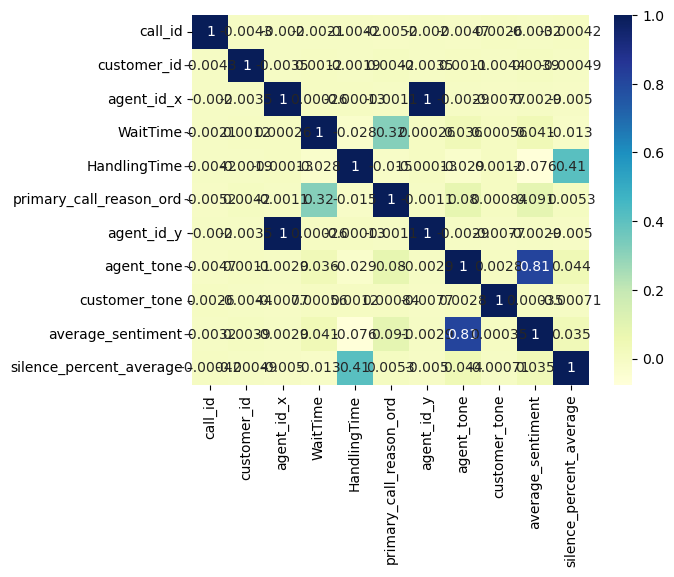

In [37]:
# Correlation heatmap
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

# Import file with data
data = merged_df

# Plotting correlation heatmap
dataplot = sb.heatmap(data.corr(numeric_only=True), cmap="YlGnBu", annot=True)

# Displaying heatmap
mp.show()

In [38]:
# drop datetime and object attributes
merged_df_numeric = merged_df.select_dtypes(include=[np.number])
merged_df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66653 entries, 0 to 66652
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_id                  66653 non-null  int64  
 1   customer_id              66653 non-null  int64  
 2   agent_id_x               66653 non-null  int64  
 3   WaitTime                 66653 non-null  float64
 4   HandlingTime             66653 non-null  float64
 5   primary_call_reason_ord  66653 non-null  float64
 6   agent_id_y               66653 non-null  int64  
 7   agent_tone               66455 non-null  float64
 8   customer_tone            66653 non-null  int64  
 9   average_sentiment        66552 non-null  float64
 10  silence_percent_average  66653 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 5.6 MB


In [41]:
merged_df_numeric.skew()

call_id                    0.007545
customer_id               -0.002201
agent_id_x                -0.094180
WaitTime                   0.089539
HandlingTime               2.759415
primary_call_reason_ord    0.003558
agent_id_y                -0.094180
agent_tone                -1.223135
customer_tone             -0.001705
average_sentiment         -0.338113
silence_percent_average    0.638877
dtype: float64

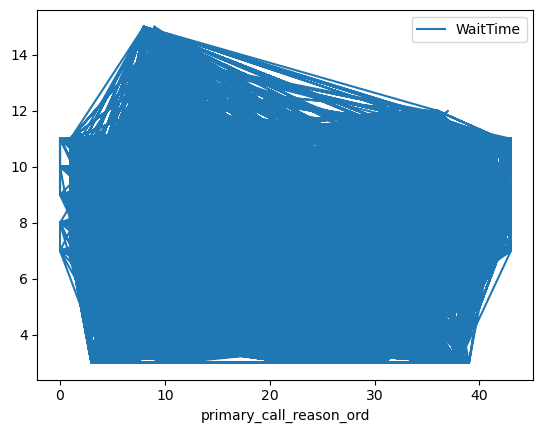

In [43]:
import matplotlib.pyplot as plt
merged_df.plot("primary_call_reason_ord","WaitTime")
plt.show()

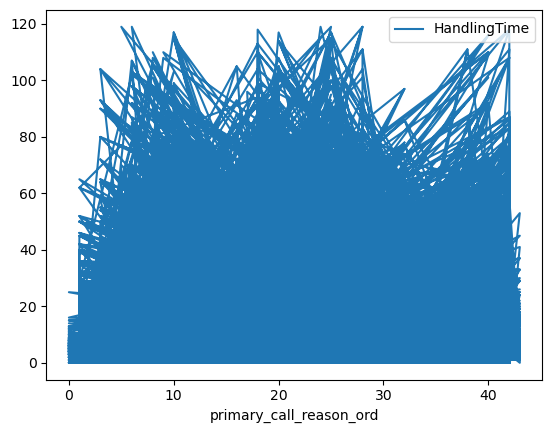

In [44]:
merged_df.plot("primary_call_reason_ord","HandlingTime")
plt.show()

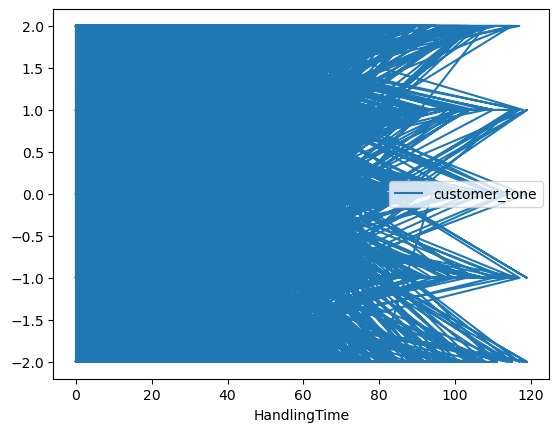

In [45]:
merged_df.plot("HandlingTime","customer_tone")
plt.show()

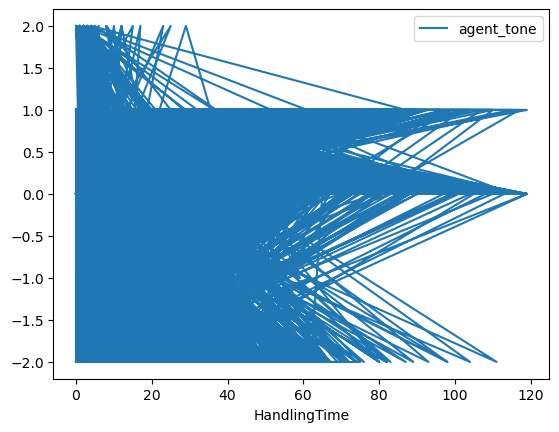

In [49]:
merged_df.plot("HandlingTime","agent_tone")
plt.show()

In [50]:
!pip install autoviz

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.4.2 which is incompatible.
ydata-profiling 4.10.0 requires visions[type_image_path]<0.7.7,>=0.7.5, but you have visions 0.7.4 which is incompatible.


Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)
Shape of your Data Set loaded: (66653, 11)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  6
    Number of Integer-Categorical Columns =  3
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number o

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
call_id,int64,0.000000,100,131642.000000,9999806100.000000,Possible ID column: drop before modeling step.
customer_id,int64,0.000000,100,443070.000000,9999935113.000000,Possible ID column: drop before modeling step.
agent_id_x,int64,0.000000,0,102574.000000,993862.000000,No issue
WaitTime,float64,0.000000,NA,3.000000,15.000000,No issue
HandlingTime,float64,0.000000,NA,0.000000,119.000000,Column has 4700 outliers greater than upper bound (31.50) or lower than lower bound(-12.50). Cap them or remove them.
primary_call_reason_ord,float64,0.000000,NA,0.000000,43.000000,No issue
agent_id_y,int64,0.000000,0,102574.000000,993862.000000,Column has a high correlation with ['agent_id_x']. Consider dropping one of them.
agent_tone,float64,0.297061,NA,-2.000000,2.000000,"198 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 3438 outliers greater than upper bound (2.50) or lower than lower bound(-1.50). Cap them or remove them., Column has a high correlation with ['average_sentiment']. Consider dropping one of them."
customer_tone,int64,0.000000,0,-2.000000,2.000000,No issue
average_sentiment,float64,0.151531,NA,-1.380000,2.670000,"101 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 2346 outliers greater than upper bound (0.29) or lower than lower bound(-0.35). Cap them or remove them."


Number of All Scatter Plots = 21


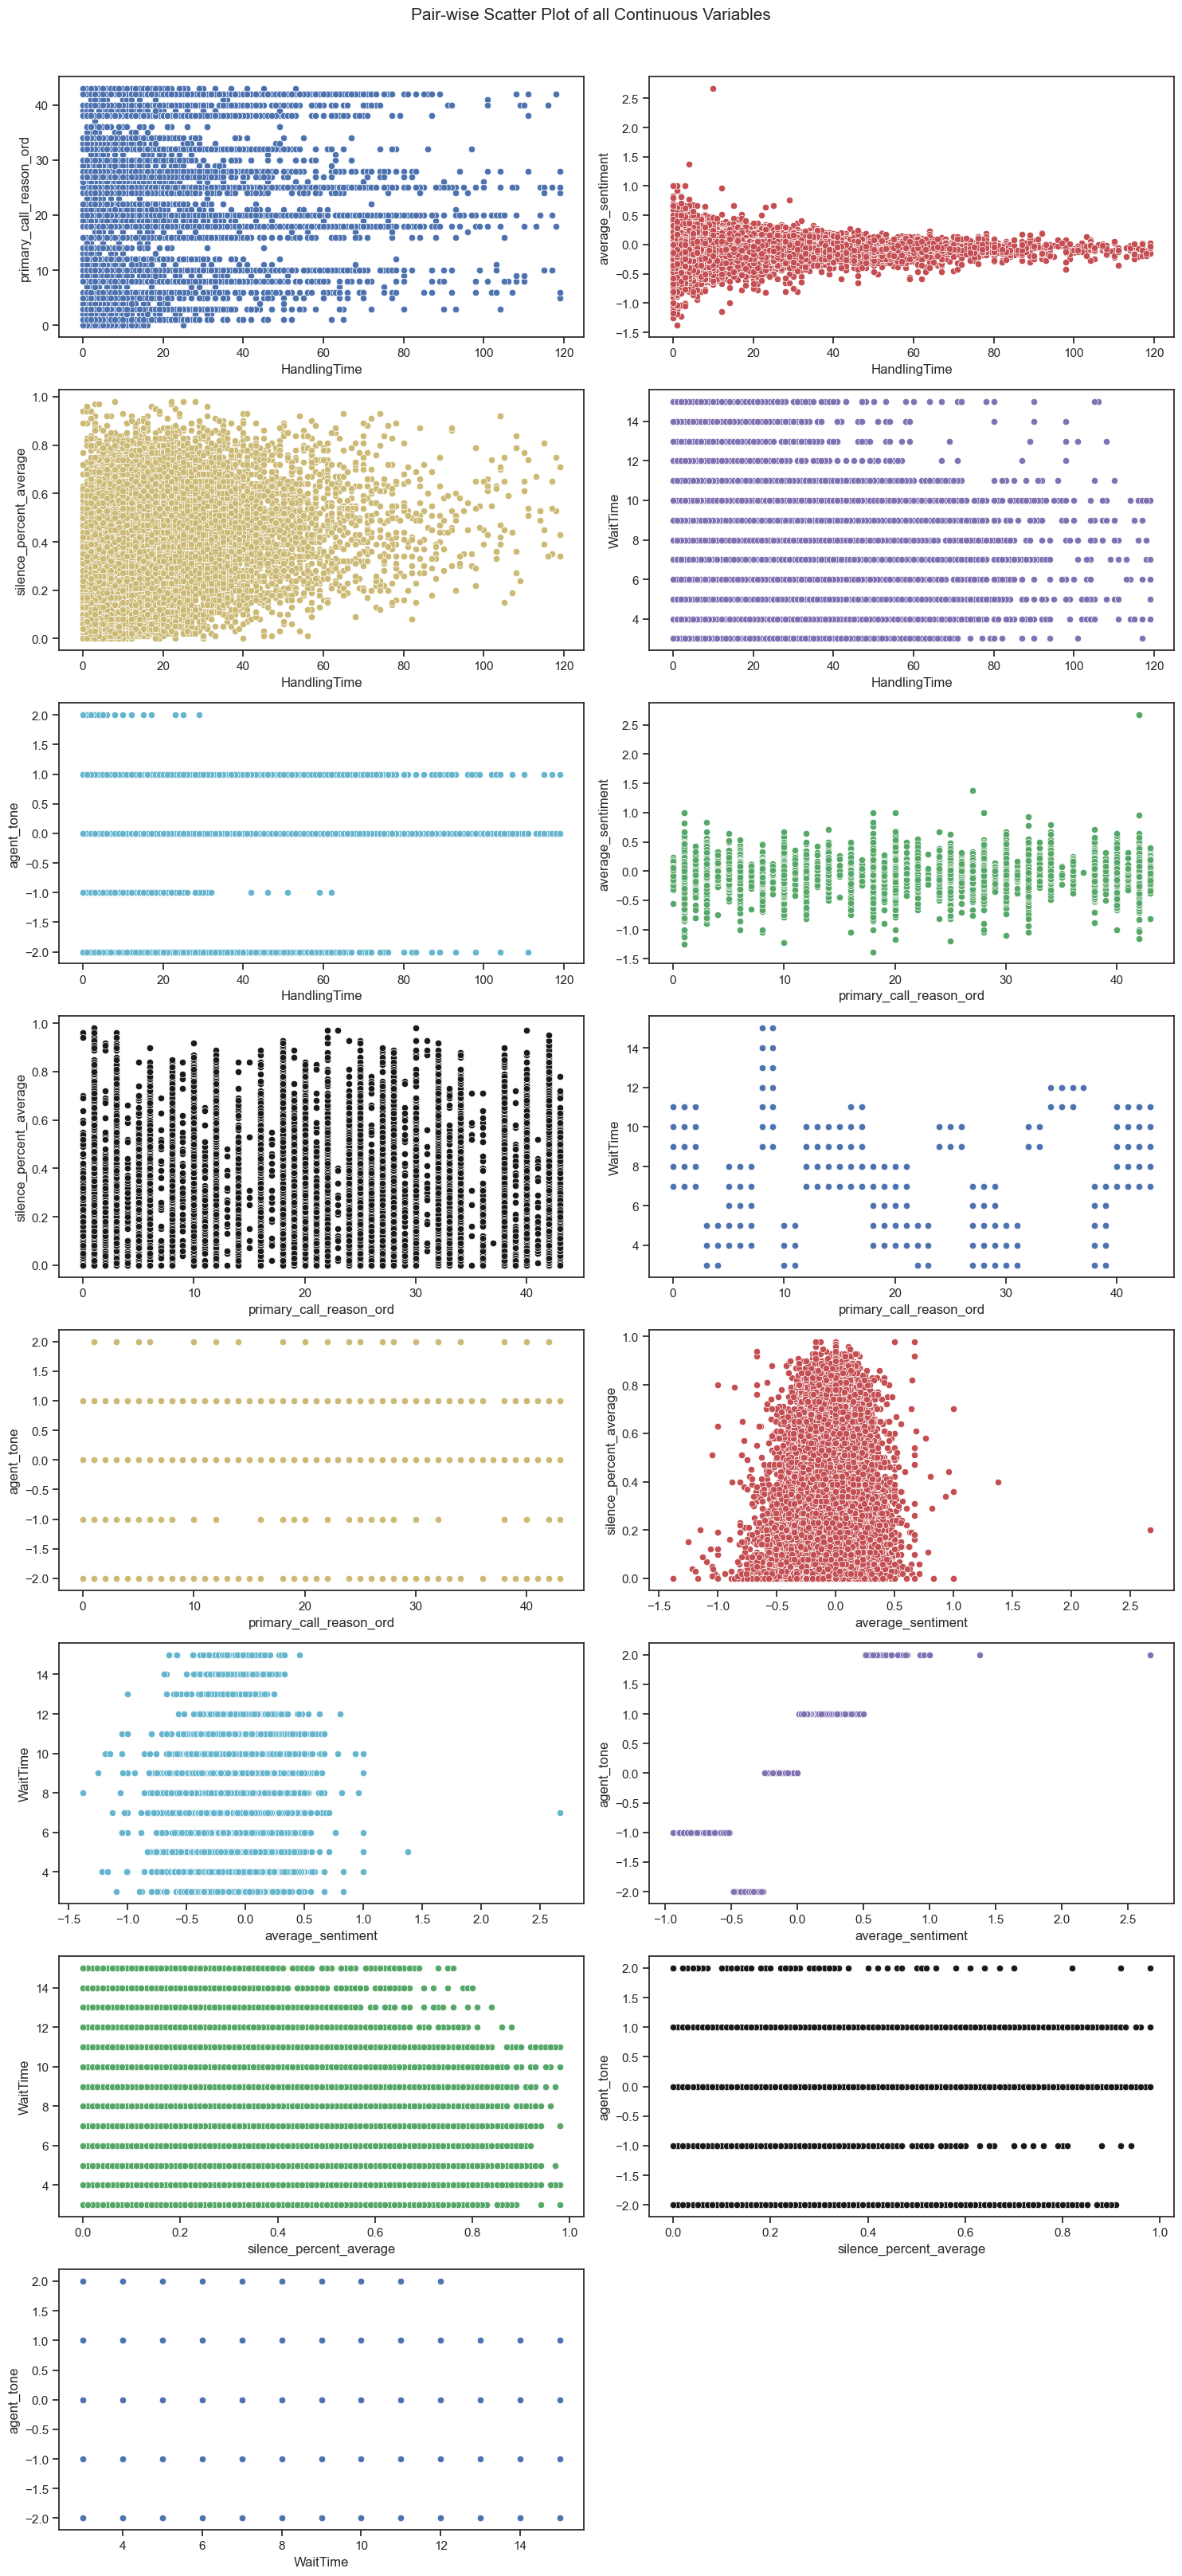

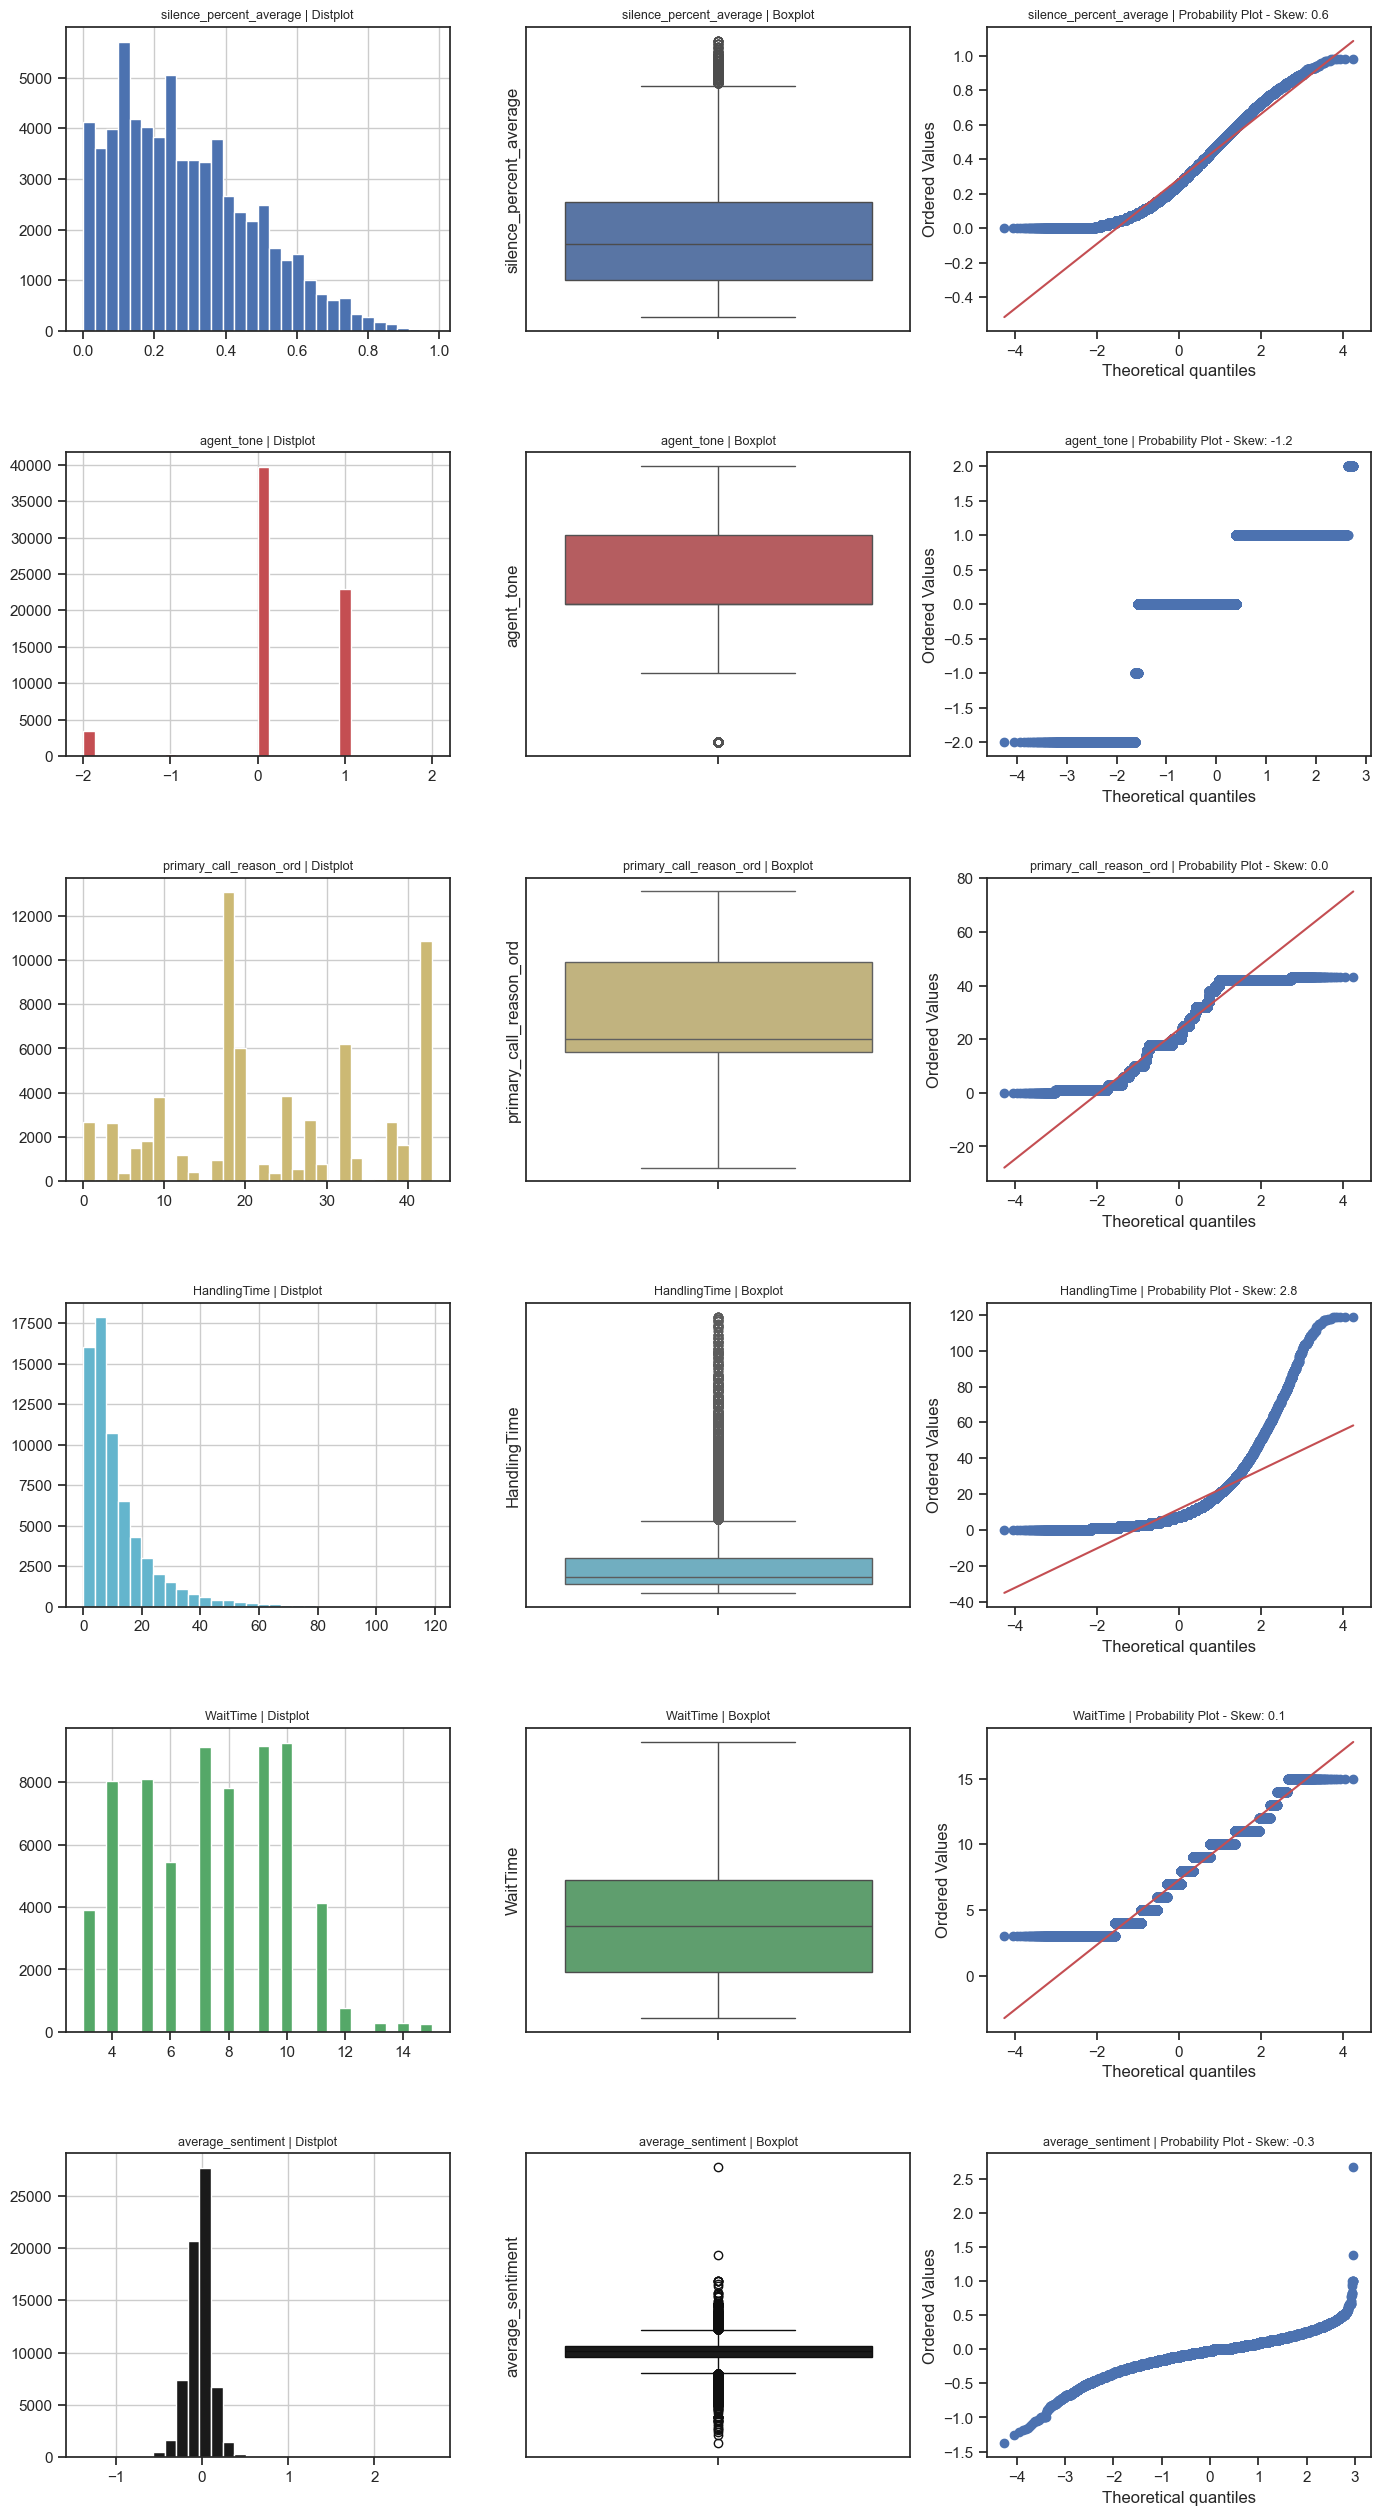

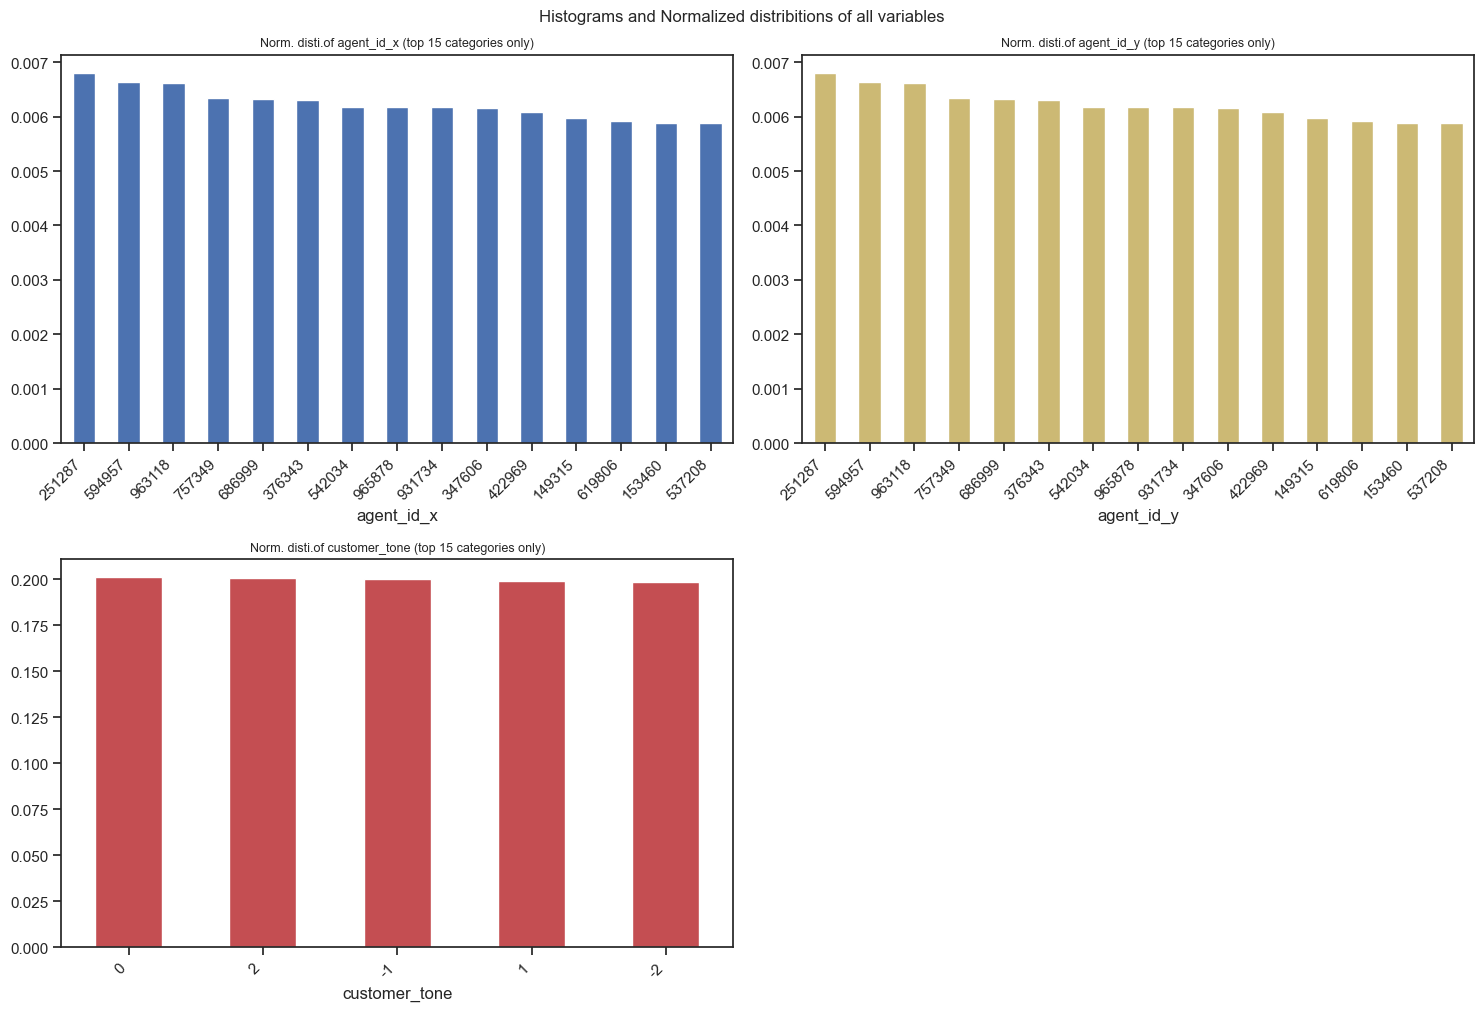

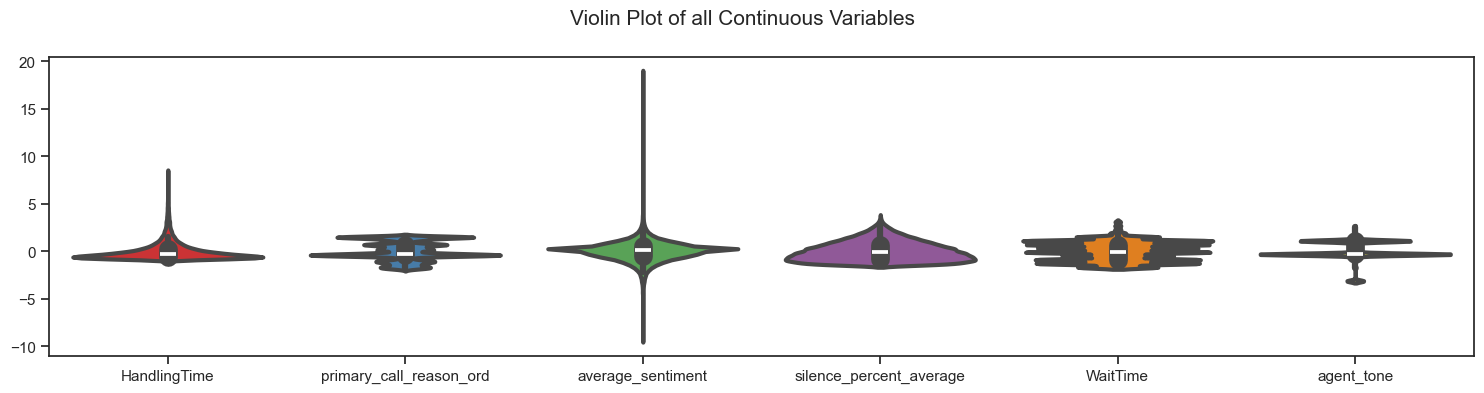

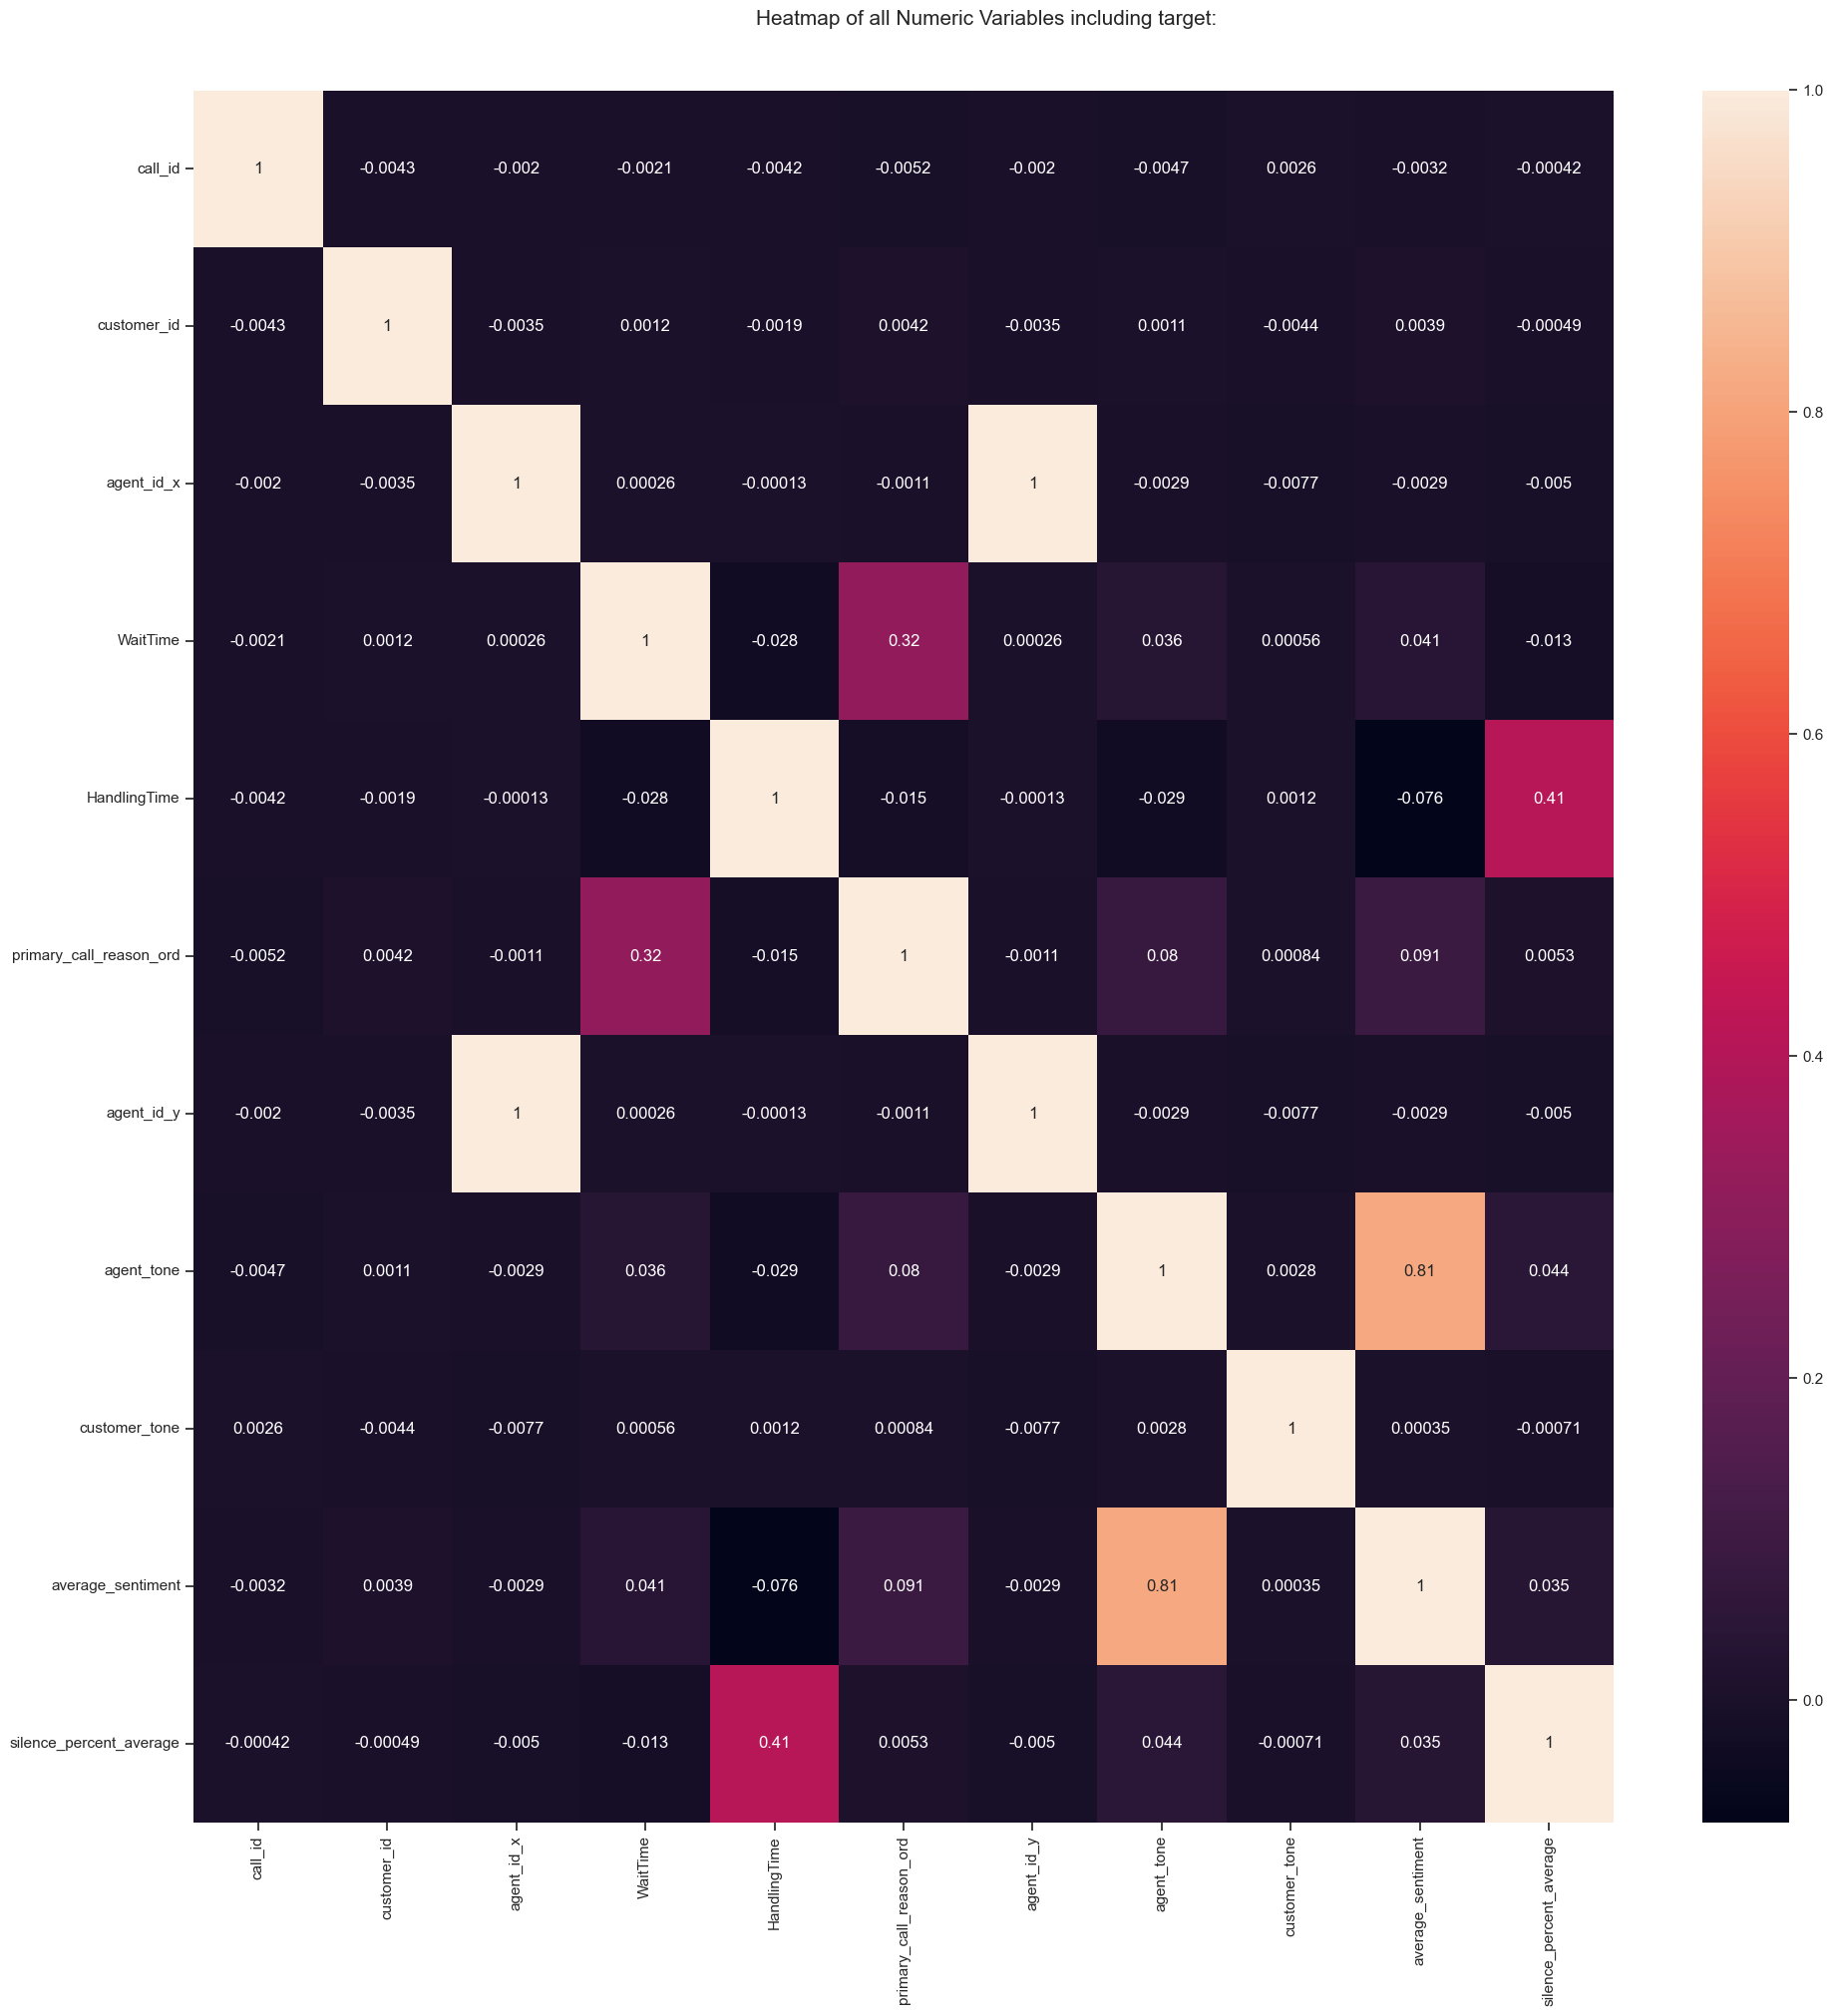

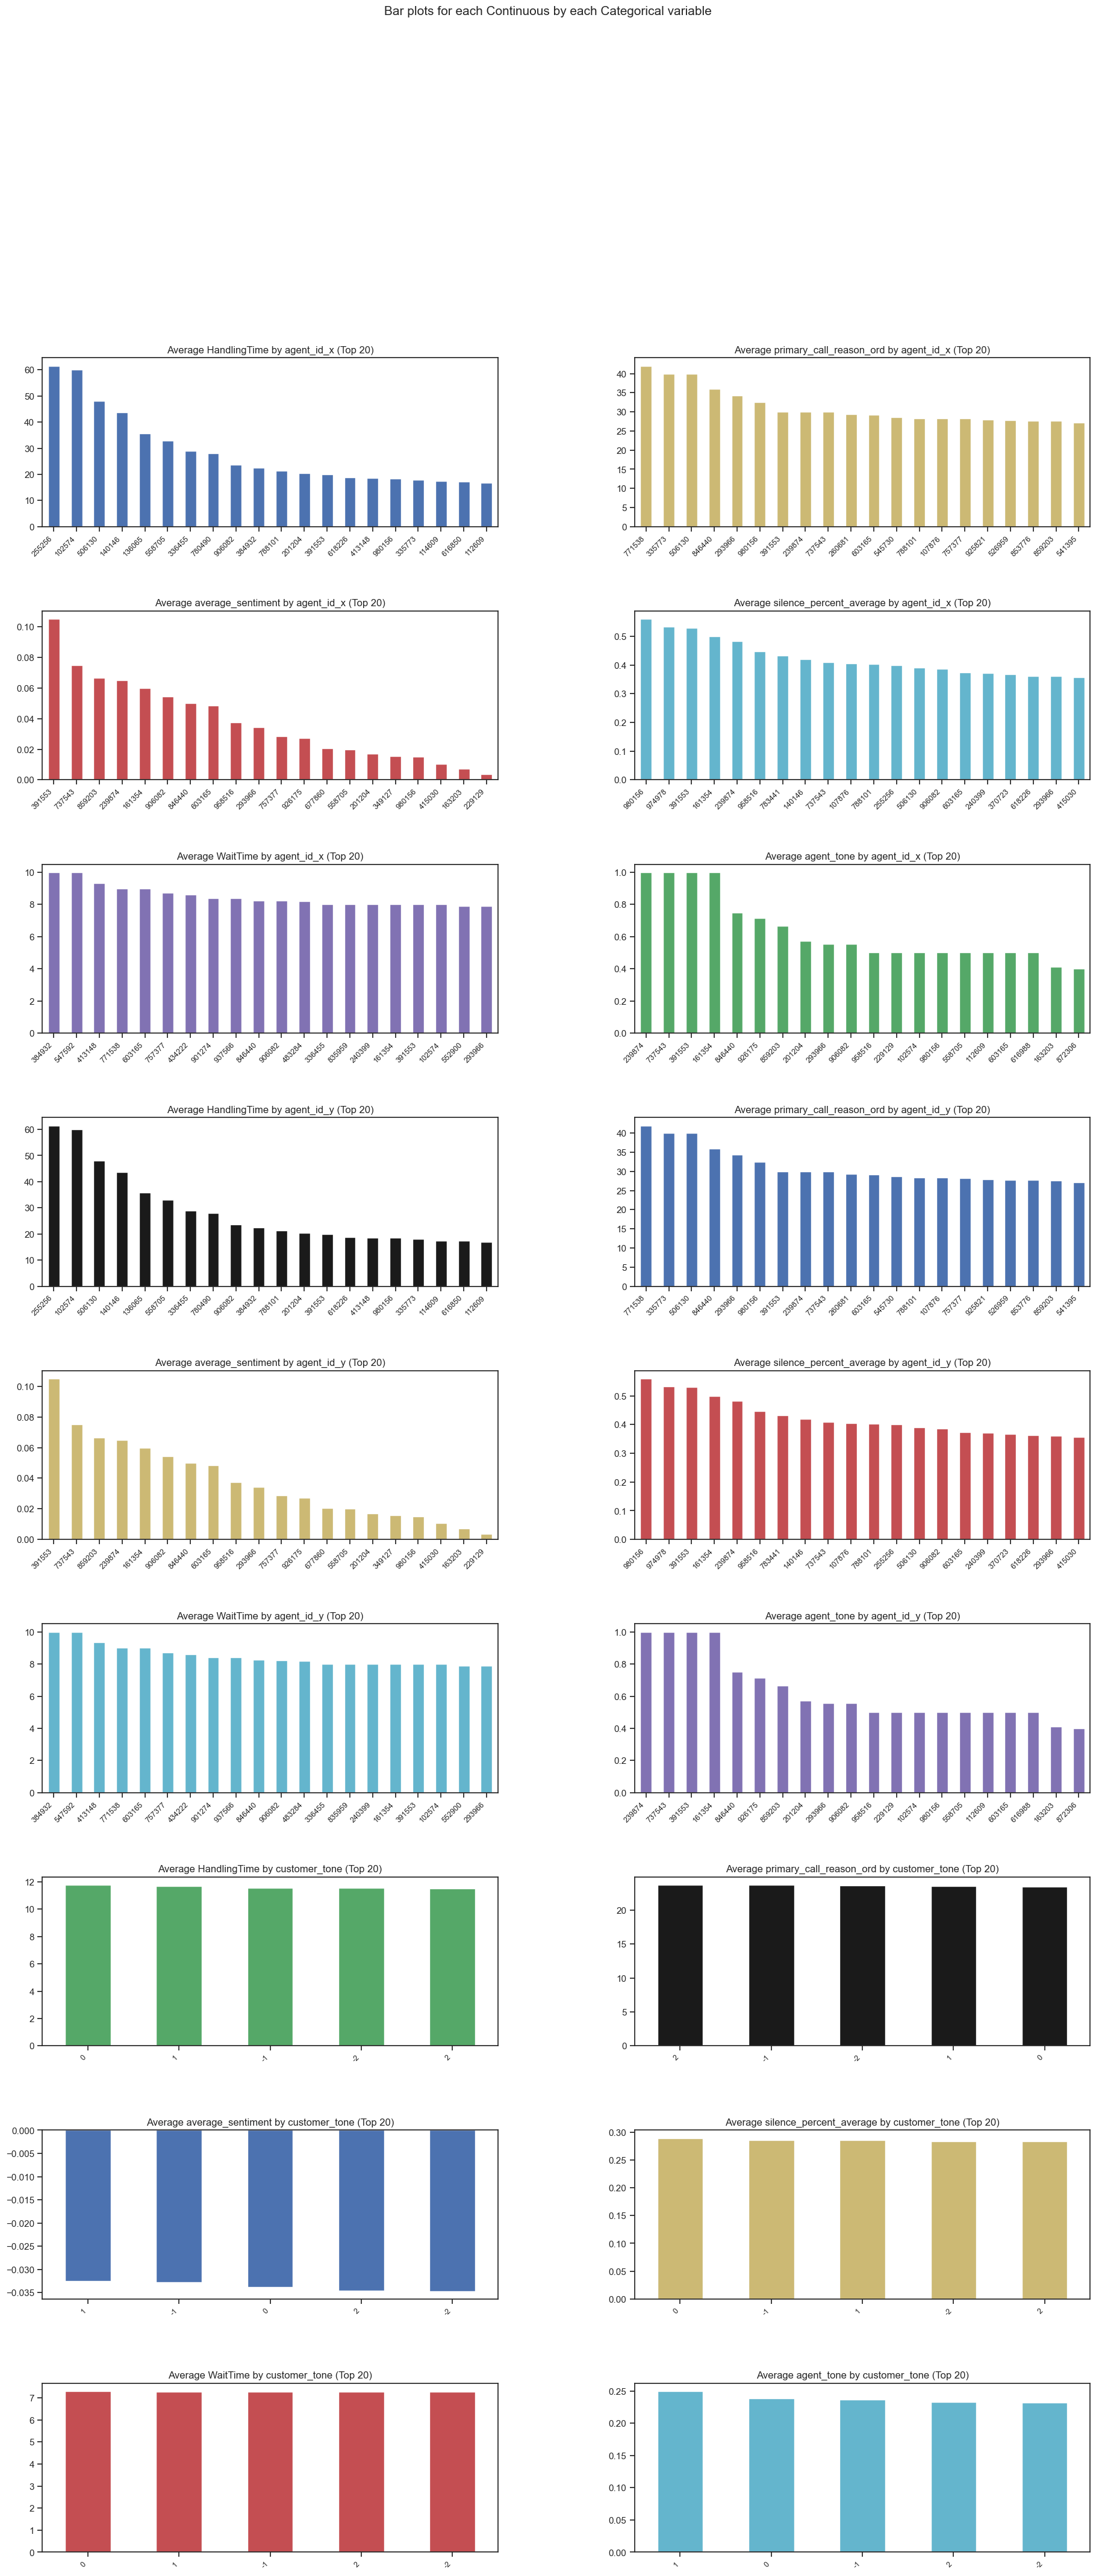

All Plots done
Time to run AutoViz = 13 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [52]:
from autoviz.AutoViz_Class import AutoViz_Class
AV=AutoViz_Class()
import matplotlib.pyplot as plt
%matplotlib inline
df=merged_df_numeric
dft= AV.AutoViz(df)

In [59]:
# merged_df  the main dataset

# plots for primari call reason and handelling time

merged_df.head()

,call_id,customer_id,agent_id_x,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,WaitTime,HandlingTime,primary_call_reason,primary_call_reason_ord,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,"\n\nAgent: Thank you for calling United Airlines customer service, my name is Sarah how may I help you?\n\nCustomer: Hi, yeah I'm calling because my flight from Chicago to New York was delayed by over 3 hours! This is ridiculous, I'm missing important meetings because of this. \n\nAgent: I'm so sorry to hear about the delay, that's definitely frustrating. Umm, let me pull up your reservation and take a look at what happened. *typing sounds* Okay, it looks like there was severe weather in Chicago that caused multiple flight cancellations and delays across the board for all the airlines. Ahh shoot, yeah your original flight was scheduled to depart at 2pm but didn't actually take off until after 5pm.\n\nCustomer: Ugh this is such poor planning on United's part, you should have rerouted passengers or put us on other flights that weren't delayed. Now I've wasted a whole day. \n\nAgent: I understand your frustration sir, delays are never fun. Let me see what options I have available to help make this up to you. Hmm, it looks like I can get you booked on a flight leaving at 3pm tomorrow that will have you landing in New York by 5pm. I'll waive the change fee and provide you with a travel voucher for $200 to help cover expenses from the missed meetings today. Does that work for your schedule?\n\nCustomer: I guess that's better than nothing. But you really need to get your act together, this is unacceptable customer service from United. Your delays are costing people time and money. \n\nAgent: You're right, we want to do better for our customers. I apologize again for the delay and inconvenience. Thank you for flying with us and I hope the rescheduled flight and travel credit help make up for some of the trouble today. Please feel free to reach back out if you have any other issues. Thanks for your patience and for understanding - I appreciate you taking the time to work through this with me.\n\nCustomer: Alright fine. This better not happen again next time I fly United. \n\nAgent: I'll be sure to note your record so we can try and avoid any repeats going forward. Take care and have a good rest of your day.\n\nCustomer: Yeah, you too. *hangs up*\n\nAgent: Thank you for your call, next caller please. *pretends to answer another call* Hi there, thank you for calling United how can I help?",7.0,31.0,Voluntary Cancel,40.0,963118,0.0,-1,-0.04,0.39
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,"\n\nAgent: Thank you for calling United Airlines, my name is Sam, how can I help you today?\n\nCustomer: Hi Sam, yeah I'm calling because I need to change the dates on my upcoming flight. My flight is booked for next Thursday but something came up and I need to fly out on Monday instead.\n\nAgent: No problem, let me pull up your reservation so I can take a look. Can I get your last name and confirmation number please? \n\nCustomer: Sure, last name is Smith, confirmation number is ASDF456. *makes noise in background* Sorry, the kids are being loud over here. \n\nAgent: No worries, let me see... Okay Mr. Smith, I've got your reservation here for flight UA128 next Thursday. Just giving the availability a check for Monday... Umm it looks like we do have seats available on a flight leaving earlier that day. The fare would be an additional $100 each way though. How does that work for you?\n\nCustomer: Ah man, an extra $100? That's more than I was hoping to pay. Is there any way to get on that flight for the same price as my original ticket? Money is a little tight right now. \n\nAgent: I understand, flight changes usually do incur a fee unfortunately. Let me take a look at 

In [57]:
merged_df_numeric.head()

,call_id,customer_id,agent_id_x,WaitTime,HandlingTime,primary_call_reason_ord,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,7.0,31.0,40.0,963118,0.0,-1,-0.04,0.39
1,1122072124,8186702651,519057,3.0,12.0,3.0,519057,1.0,0,0.02,0.35
2,6834291559,2416856629,158319,8.0,19.0,18.0,158319,0.0,2,-0.13,0.32
3,2266439882,1154544516,488324,5.0,7.0,38.0,488324,0.0,-2,-0.20,0.20
4,1211603231,5214456437,721730,10.0,9.0,32.0,721730,0.0,2,-0.05,0.35


## plotting the grphs of important features

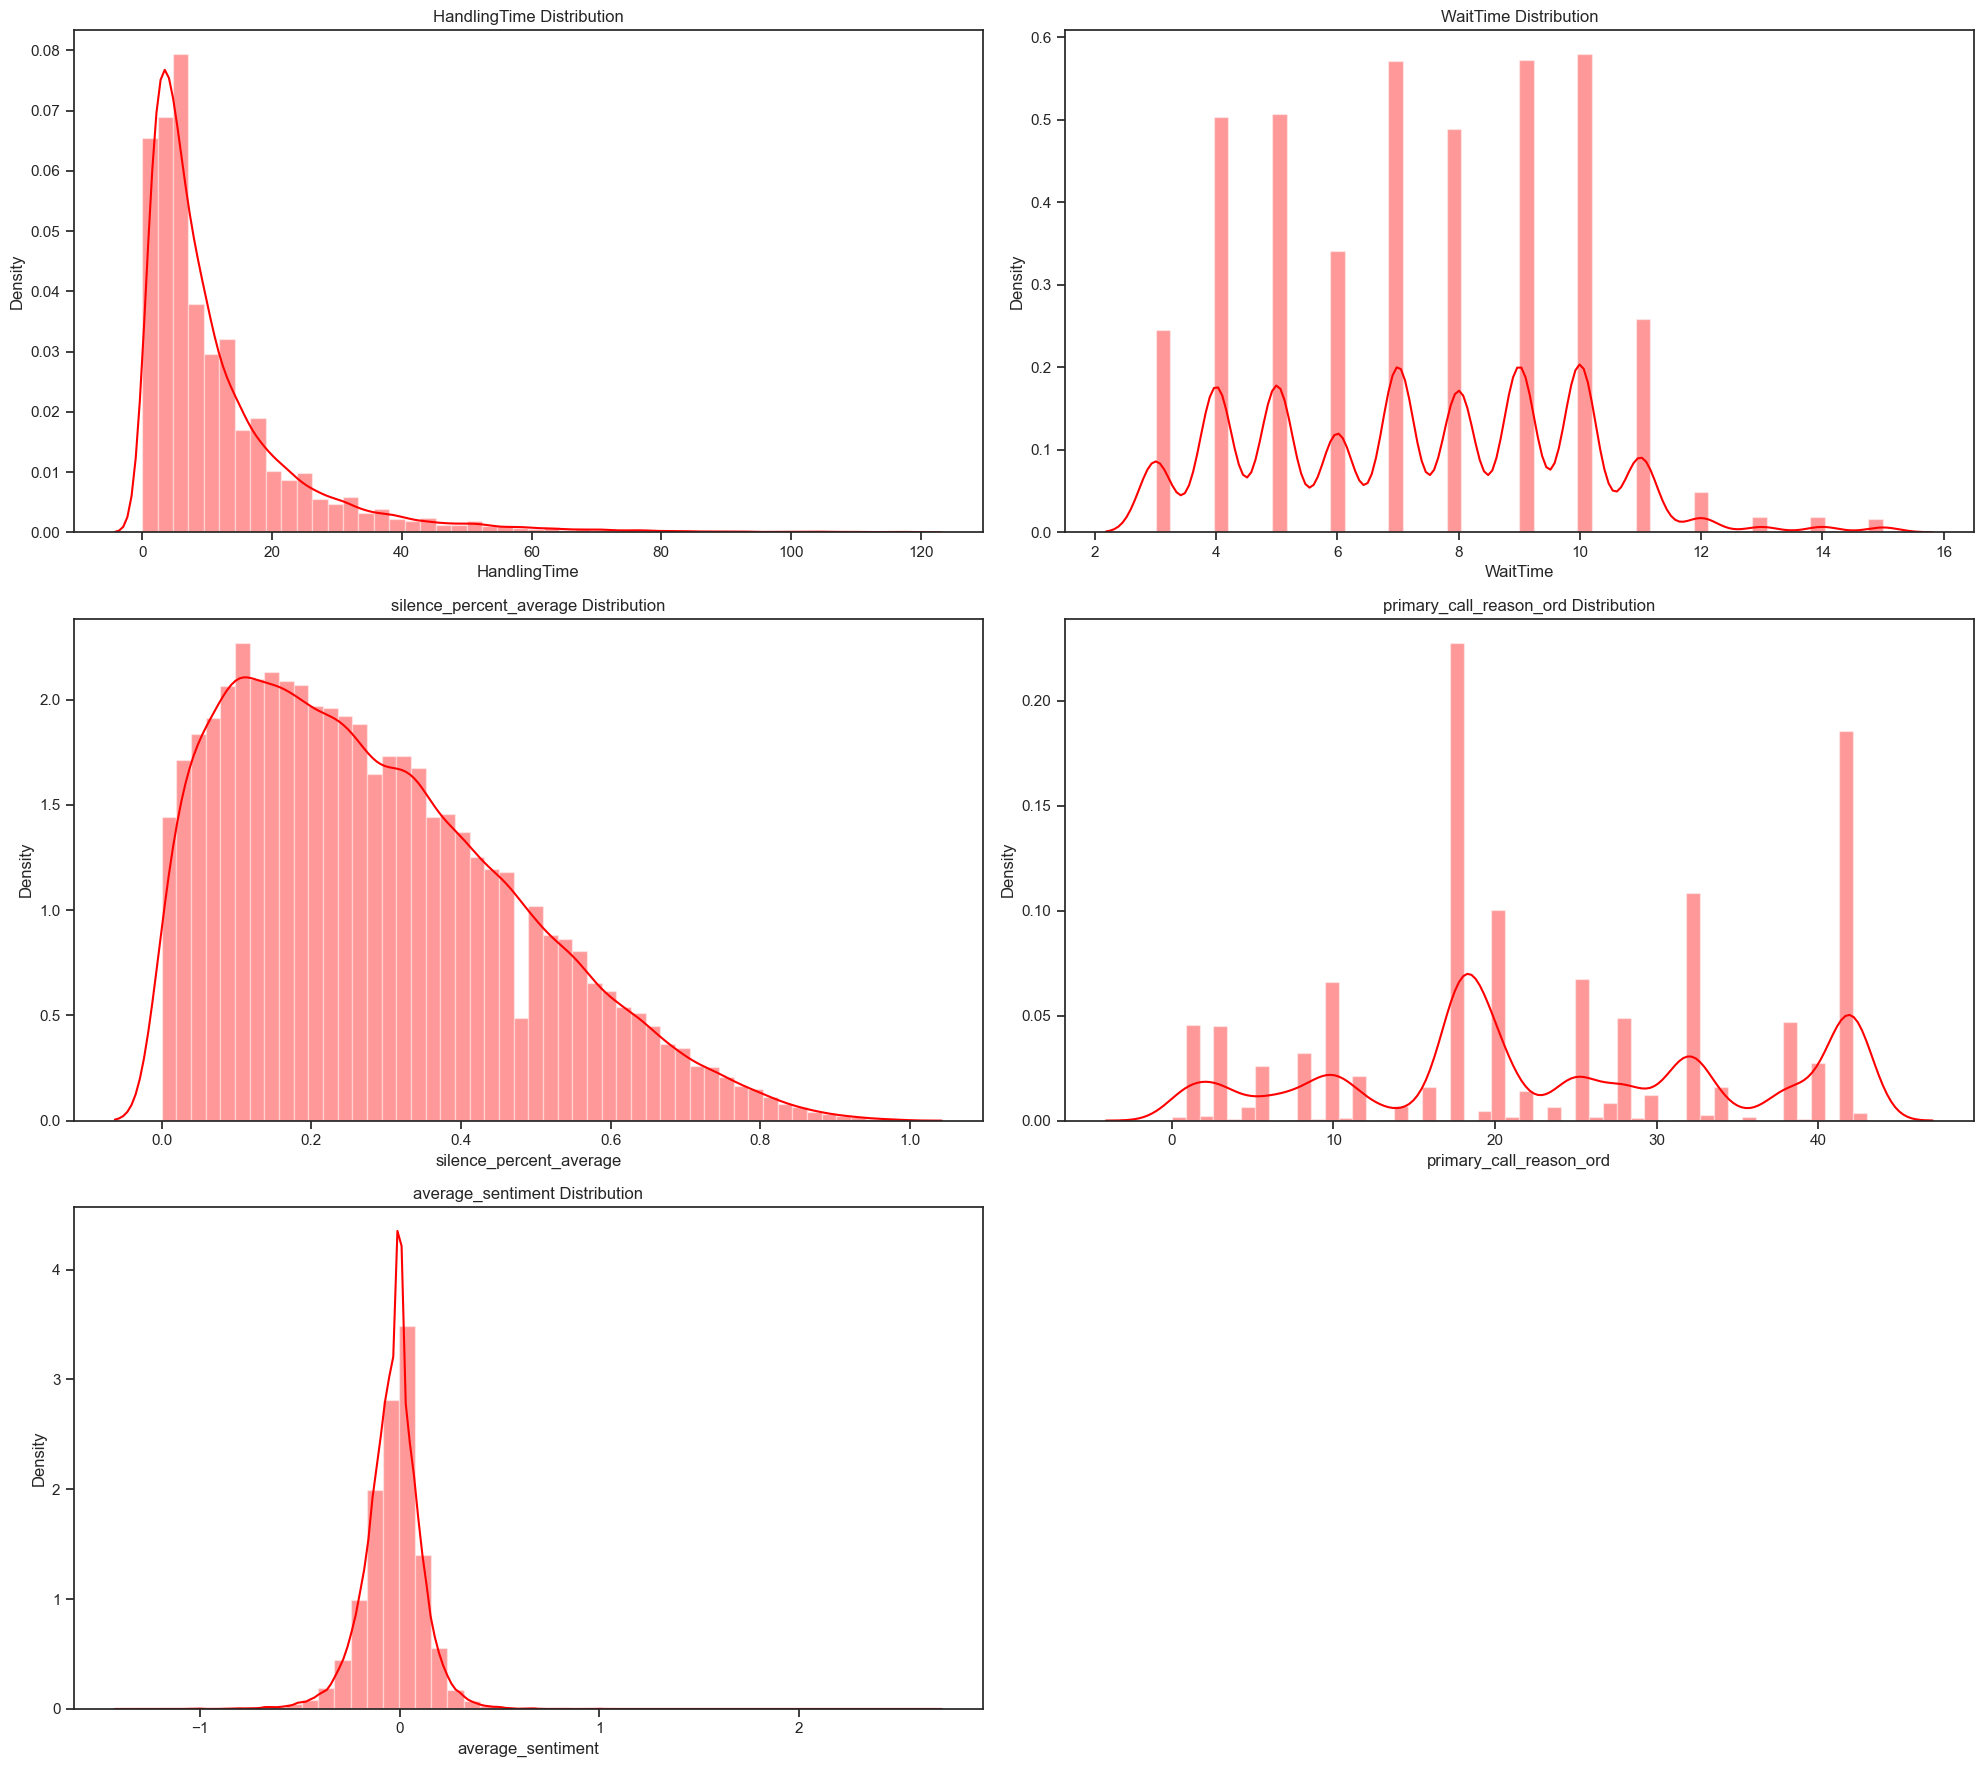

In [76]:
import seaborn as sns
cols = ['HandlingTime','WaitTime','silence_percent_average','primary_call_reason_ord']
x=1

plt.figure(figsize=(20,35))
for i in cols:
    plt.subplot(6,2,x)
    sns.distplot(merged_df_numeric[i],color="RED")
    plt.title(f"{i} Distribution")
    plt.tight_layout()
    x+=1


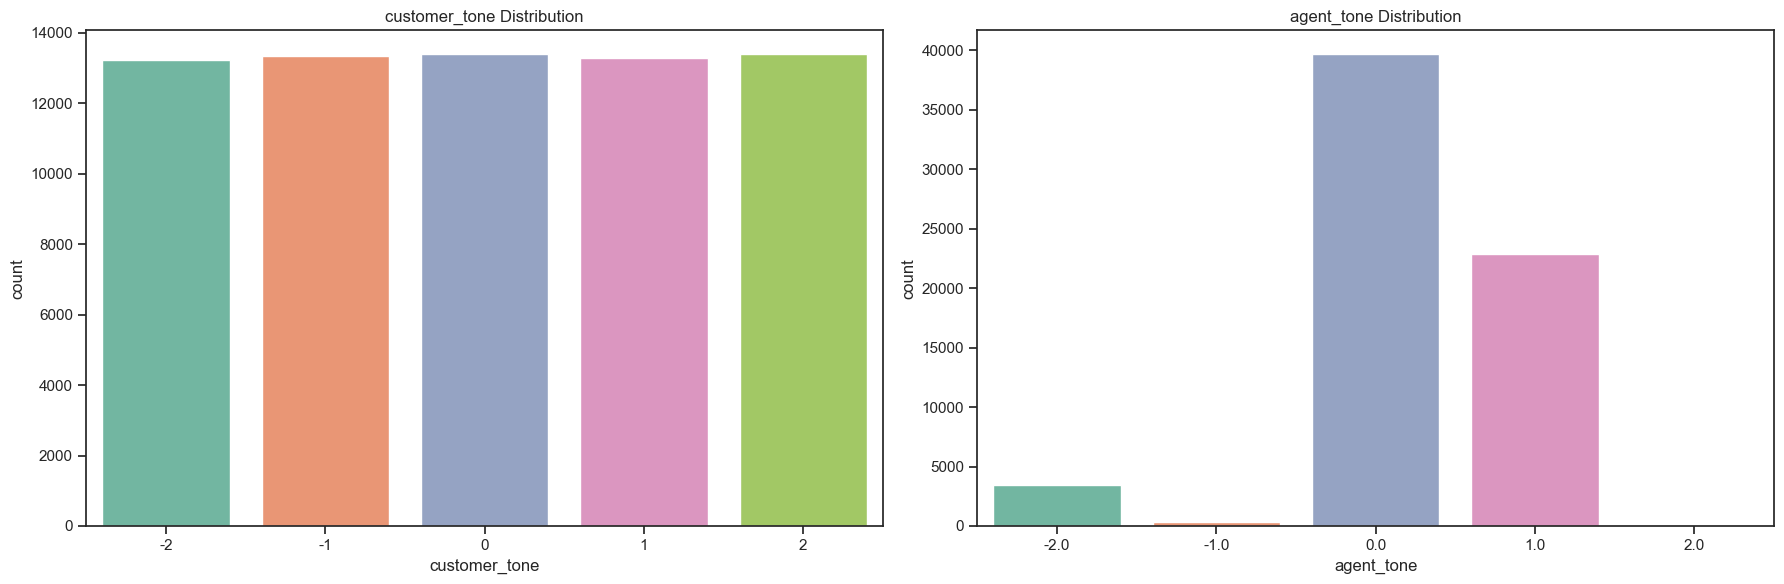

In [88]:
cols = ["customer_tone","agent_tone"]

plt.figure(figsize=(18,6))
for idx,column in enumerate(cols):
    plt.subplot(1,2,idx+1)
    sns.countplot(x=column, data=merged_df_numeric, palette="Set2")
    plt.title(f"{column} Distribution")
    plt.tight_layout()